# Quantum Newton Raphson on Net0 with VQLS linear solver

In this example, we use the VQLS solver to drive the Newton-Raphson algorithm to obtain the pressure and flow rate of a small network, Net0:

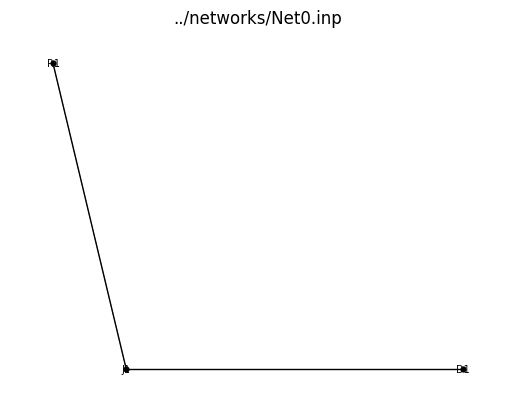

<Axes: title={'center': '../networks/Net0.inp'}>

In [4]:
import os
import wntr
import wntr_quantum

# if not done in shell, define the environment variable here
os.environ["EPANET_TMP"] = "/home/nico/.epanet_quantum"
os.environ["EPANET_QUANTUM"] = "/home/nico/QuantumApplicationLab/vitens/EPANET"

# set up network model
inp_file = "../networks/Net0.inp"
wn = wntr.network.WaterNetworkModel(inp_file)

# plot network
wntr.graphics.plot_network(wn, title=wn.name, node_labels=True)


In [5]:
# define the classical EPANET simulator
sim = wntr.sim.EpanetSimulator(wn)

# run the EPANET simulation
results_epanet = sim.run_sim()

# save number of nodes and pipes
n_nodes = (len(results_epanet.node["pressure"].iloc[0]),)
n_pipes = len(results_epanet.link["flowrate"].iloc[0])

results_epanet.node["pressure"], results_epanet.link["flowrate"]

(name         J1         D1            R1
 0     29.647692  19.167677 -9.338379e-07
 3600  29.647692  19.167677 -9.338379e-07,
 name    P1    P2
 0     0.05  0.05
 3600  0.05  0.05)

### Solve water network with `QuantumEpanetSimulator` and VQLS 

We now solve the model using VQLS. In this example, we are **preconditioning** the initial linear system using *diagonal scaling* and also using a **mix of two classical optimizers**.

In [6]:
import numpy as np
from wntr_quantum.linear_solver import VQLS_SOLVER
from qiskit.primitives import Estimator
from qiskit.circuit.library import RealAmplitudes
from qiskit_algorithms.optimizers import CG, COBYLA, ADAM, SPSA, AQGD
from utils import compare_results 

n_qubits = 1
# define the ansatz
qc = RealAmplitudes(n_qubits, reps=5, entanglement="full")

# define estimator
estimator = Estimator()

# define the solver
linear_solver = VQLS_SOLVER(
    estimator=estimator,
    ansatz=qc,
    optimizer=[COBYLA(maxiter=500), CG(disp=True, maxiter=50)],
    matrix_decomposition="symmetric",
    verbose=True,
)

sim = wntr_quantum.sim.QuantumEpanetSimulator(wn, linear_solver=linear_solver)
results_hhl = sim.run_sim(linear_solver=linear_solver)

classical_res, quantum_res = compare_results(results_epanet, results_hhl)

results_hhl.node["pressure"], results_hhl.link["flowrate"]

/tmp/ipykernel_5058/2415584772.py:13: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


/home/nico/QuantumApplicationLab/vitens/wntr-quantum/wntr_quantum/epanet/Linux/libepanet22_amd64.so
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 7
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 7
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 7
         Gradient evaluations: 1
Quantum result 0.04998798668384552 within 0.024028122066551864% of classical result 0.05000000074505806
Quantum result 0.0499880313873291 within 0.023938715100722832% of classical result 0.05000000074505806
Quantum result 29.647850036621094 within 0.0005339705295874499% of classical result 29.64769172668457
Quantum result 19.17258644104004 within 0.025613512789788843% of classical result 19

(name         J1         D1            R1
 0     29.647850  19.172586 -9.338379e-07
 3600  29.647568  19.163879 -9.338379e-07,
 name        P1        P2
 0     0.049988  0.049988
 3600  0.050009  0.050009)

### Plot pressures and flow rates

Let's check graphically the equivalence of the results.

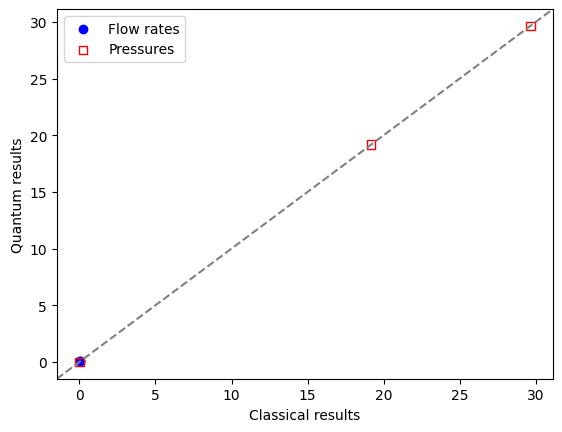

In [7]:
import matplotlib.pyplot as plt

plt.scatter(
    classical_res[:n_pipes],
    quantum_res[:n_pipes],
    label="Flow rates",
    color="blue",
    marker="o",
)
plt.scatter(
    classical_res[n_pipes:],
    quantum_res[n_pipes:],
    label="Pressures",
    color="red",
    marker="s",
    facecolors="none",
)
plt.axline((0, 0), slope=1, linestyle="--", color="gray", label="")
plt.xlabel("Classical results")
plt.ylabel("Quantum results")
plt.legend()
plt.show()

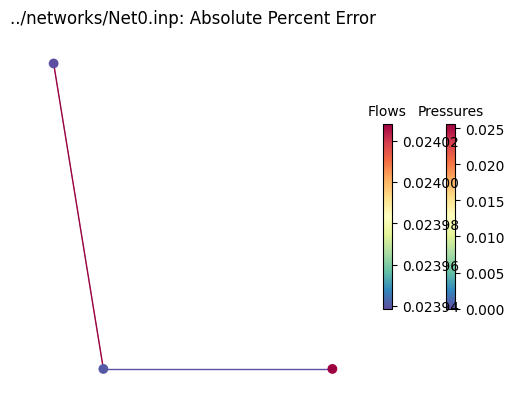

<Axes: title={'center': '../networks/Net0.inp: Absolute Percent Error'}>

In [8]:
from utils import get_ape_from_pd_series

wntr.graphics.plot_network(
    wn,
    node_attribute=get_ape_from_pd_series(
        results_hhl.node["pressure"].iloc[0], results_epanet.node["pressure"].iloc[0]
    ),
    link_attribute=get_ape_from_pd_series(
        results_hhl.link["flowrate"].iloc[0],
        results_epanet.link["flowrate"].iloc[0],
    ),
    node_colorbar_label="Pressures",
    link_colorbar_label="Flows",
    node_size=50,
    title=f"{inp_file}: Absolute Percent Error",
    node_labels=False,
)